In [1]:
from active_learning.util_classes import (
    DimensionlessDataset,
    DimensionlessAnnotationUnit,
    DimensionlessIndex,
    ALAttribute
)
from active_learning.agent import ActiveLearningAgent
from active_learning.selector import DimensionlessSelector
from active_learning.acquisition import *
from active_learning.batch_querying import SequentialKMeansBatchQuerying, NoPolicyBatchQuerying
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch import optim
from tqdm import tqdm
import time
import datetime
import pandas as pd
import json
import glob
import pylab as pl
from IPython import display
from torch.utils.data import BatchSampler, SubsetRandomSampler

In [2]:
def generate_dataset():
    
    points_per_class = 500
    
    pre_sigma_1 = np.array([[100, 44], [3, 11]])
    sigma_1 = pre_sigma_1 + pre_sigma_1.T
    cluster_1 = np.random.multivariate_normal([0, 0], sigma_1, size = points_per_class)
    cluster_1 = np.concatenate([cluster_1.T, np.ones(points_per_class).reshape(1, points_per_class)]).T

    pre_sigma_2 = np.array([[70, -20], [-3, 6]])
    sigma_2 = pre_sigma_2 + pre_sigma_2.T
    cluster_2 = np.random.multivariate_normal([18, 16], sigma_2, size = points_per_class)
    cluster_2 = np.concatenate([cluster_2.T, 2*np.ones(points_per_class).reshape(1, points_per_class)]).T

    pre_sigma_3 = np.array([[70, 5.5], [3, 10]])
    sigma_3 = pre_sigma_3 + pre_sigma_3.T
    cluster_3 = np.random.multivariate_normal([-15, 10], sigma_3, size = points_per_class)
    cluster_3 = np.concatenate([cluster_3.T, 3*np.ones(points_per_class).reshape(1, points_per_class)]).T
    
    mixed = np.concatenate([cluster_1, cluster_2, cluster_3])
    np.random.shuffle(mixed)
    
    fig, ax = plt.subplots(1)
    ax.set_aspect('equal', 'box')
    ax.scatter(mixed[:,0], mixed[:,1], c=mixed[:,2], s=4)
    
    np.savetxt("classification_dataset", mixed, delimiter=',')
    
def get_data_from_index(i):
    arr = pd.read_csv('classification_dataset', header = None).to_numpy()
    return torch.tensor(arr[i, :2])

def get_label_from_index(i):
    arr = pd.read_csv('classification_dataset', header = None).to_numpy()
    class_ = int(arr[i, 2])
    return torch.tensor([1 if j == class_-1 else 0 for j in range(3) ])

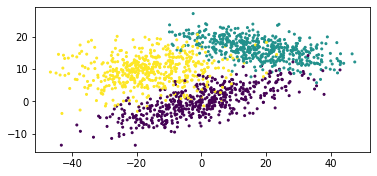

In [3]:
num_datapoints = 500*3
generate_dataset()

all_data = range(num_datapoints)
all_labels = range(num_datapoints)
X_train, X_test, y_train, y_test = train_test_split(all_data, all_labels)

In [4]:
class MulticlassNN(nn.Module):
    
    def __init__(self, input_dim=2, num_classes=3):
        super().__init__()
        self.linear = nn.Linear(input_dim, num_classes)
        
    def forward(self, x, anneal = None):
        x = x.float()
        psi = self.linear(x)
        return {
            "last_preds": nn.functional.log_softmax(psi, dim = 1),
            "embeddings": psi
        }

In [5]:
class Criterion(nn.Module):
    
    def __init__(self):
        super().__init__()
        
    def forward(self, pred_log_probs, target_probs, self_supervision_mask):
        # loss of size [batch, length, classes]
        loss = - pred_log_probs * target_probs
        loss *= self_supervision_mask
        # loss of size [batch, length]
        return loss.sum()

In [6]:
def train_epoch(model, agent, optimiser, criterion):
    
    for idx, batch_indices in enumerate(agent.labelled_set):
        
        model.eval()
        X_batch, y_batch, _, ssm = agent.train_set.get_batch(batch_indices, labels_important=True)
        model.train()
        X_batch.float()
        
        optimiser.zero_grad()
        output = model(X_batch)["last_preds"]
        
        loss = criterion(output, y_batch, ssm)
        loss.backward()
        optimiser.step()

In [7]:
def eval_epoch(model, test_set):
    
    sampler = list(BatchSampler(SubsetRandomSampler(list(range(len(test_set)))), 64, drop_last=False))
    
    total = 0
    correct = 0
    
    for idx, batch_indices in enumerate(sampler):
        
        model.eval()
        X_batch, y_batch, _, ssm = test_set.get_batch(batch_indices, labels_important=True)
        X_batch.float()
        
        output = model(X_batch)["last_preds"].detach().numpy()
        preds = np.argmax(output, axis=-1) + 1
        labels = (np.argmax(y_batch, axis=-1) + 1).numpy()
        
        total += len(labels)
        correct += sum(labels == preds)
        
    return correct/total

In [84]:
round_size = 40
batch_size = 16
device = 'cpu'

helper = None
model = MulticlassNN()

train_set = DimensionlessDataset(
    data=X_train, labels=y_train, index_class=DimensionlessIndex, semi_supervision_multiplier=0.2,
    data_reading_method=get_data_from_index, label_reading_method=get_label_from_index,
    al_attributes = [
        ALAttribute(name="embeddings", initialisation=[np.nan for l in y_train], cache=True),
    ]
)
val_set = DimensionlessDataset(
    data=X_test, labels=y_test, index_class=DimensionlessIndex, semi_supervision_multiplier=0.2,
    data_reading_method=get_data_from_index, label_reading_method=get_label_from_index
)

for i in range(len(val_set)):
    val_set.index.label_instance(i)

selector = DimensionlessSelector(
    round_size=round_size, 
    acquisition=MaximumEntropyAcquisition(train_set),
    #acquisition=PredsKLAcquisition(train_set),
    #acquisition=RandomBaselineAcquisition(train_set),
    window_class=DimensionlessAnnotationUnit,
    diversity_policy=NoPolicyBatchQuerying()
    #diversity_policy=SequentialKMeansBatchQuerying(round_size, "last_preds")
)

In [85]:
agent = ActiveLearningAgent(
    train_set=train_set,
    selector_class=selector,
    round_size=round_size,
    batch_size=batch_size,
    helper=helper,
    device=device,
    model=model,
    propagation_mode=0,
)

agent.init(int(len(train_set) * 0.05))
print(sum(agent.train_set.index.labelled_idx.values()))

100%|██████████| 1125/1125 [00:00<00:00, 159708.65it/s]

56


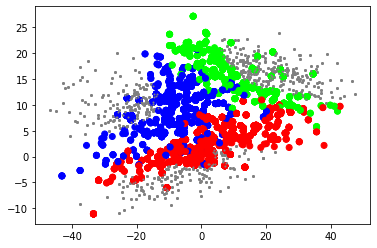

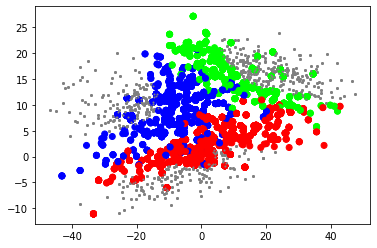

In [86]:
lr = 0.001
num_epoch = 10
criterion = Criterion()
optimiser = optim.SGD(model.parameters(), lr = lr)

performance_history = []

for _ in agent:
    
    print(agent.budget)
    
    for epoch in range(num_epoch):
        train_epoch(model, agent, optimiser, criterion)
        
    performance_history.append(eval_epoch(model, val_set))
    
    all_labelled_list = []
    for _batch_idx in agent.labelled_set:
        all_labelled_list.extend(_batch_idx)
        
    all_unlabelled_list = []
    for _u_batch_idx in agent.unlabelled_set:
        all_unlabelled_list.extend(_u_batch_idx)
        
    labelled_data, labels, _, _ = agent.train_set.get_batch(all_labelled_list, labels_important = True)
    unlabelled_data, _, _, _ = agent.train_set.get_batch(all_unlabelled_list, labels_important = False)
    
    pl.scatter(labelled_data[:,0], labelled_data[:,1] , c = labels)
    pl.scatter(unlabelled_data[:,0], unlabelled_data[:,1] , c = "grey", s = 1)
    display.clear_output(wait = True)
    display.display(pl.gcf())
    time.sleep(1.0)
    
with open(f"classification_performance_curves/{datetime.datetime.now().__str__().split()[-1]}.json", "w") as jfile:  
    json.dump({
        "acquisition": selector.acquisition.__str__(),
        "diversity": selector.diversity_policy.__str__(),
        "performance": performance_history,
        "round_size": round_size
    }, jfile)

In [87]:
def read_results(addr):

    with open(addr, "r") as jfile:
        results = json.load(jfile)
        
    acquisition = results['acquisition'].split('acquisition.')[1].split()[0]
    diversity = results['diversity'].split('batch_querying.')[1].split()[0]
    performace = results['performance']
    
    return acquisition, diversity, performace

In [76]:
df = pd.DataFrame(columns = ["RandomBaselineAcquisition", "MaximumEntropyAcquisition", "PredsKLAcquisition"],
                 index = ["NoPolicyBatchQuerying", "SequentialKMeansBatchQuerying"])
df[:] = np.zeros(df.shape).astype(int)

all_results_files = glob.glob("classification_performance_curves/*")
for results_file in all_results_files:
    acquisition, diversity, _ = read_results(results_file)
    df[acquisition][diversity] += 1

In [77]:
df

,RandomBaselineAcquisition,MaximumEntropyAcquisition,PredsKLAcquisition
NoPolicyBatchQuerying,1,1,4
SequentialKMeansBatchQuerying,0,1,3


In [ ]:
# RUN THIS AFTER A BUNCH OF ROUNDS

from sklearn.cluster import KMeans

all_preds = []
km = KMeans(n_clusters = round_size, max_iter=1)

all_data, all_preds = [], []
for d_i in range(len(train_set)):
    d = train_set[d_i]
    d.data; d_idx = d[0]
    all_data.append(get_data_from_index(d_idx))
    d.last_preds; all_preds.append(d[0])

all_data = np.vstack(all_data)
all_preds = np.exp(np.vstack(all_preds))
    
km.fit(all_preds)
colours = [km.predict(f.reshape(1, -1)) for f in all_preds]

In [ ]:
pl.scatter(all_data[:,0], all_data[:,1] , c = colours)